# Preprocessing


## Data inputs and outputs

### Inputs

Raw data are downloaded from Qualtrics as two separate datasets:

1. Survey responses in one csv, where each row corresponds to one participant.

2. Browser attributes as a folder of csv files, with each csv containing browser attributes collected from one participant.

The files are linked by the survey `Response ID` which was randomly generated by Qualtrics upon the participant entering the survey. There is a `Response ID` for each participant. This corresponds to a row in the survey responses file.
If the participant chose to share their browser attributes, there is a csv file named by this Response ID containing their browser attributes.


### Outputs

2 datasets.

Both datasets include survey responses with consistent columns corresonding to each survey question. For both datasets, a row corresponds to data from one participant, keyed by the `Response ID`.


1. survey-experiment-data.csv

This dataset is used for experiment analysis. It contains all completed responses, whether or not participants shared their browser attributes data. 
It is used to analyze which factors are most closely associated with participants' likelihood to share that data. It includes a flag indicating which experiment arm (`showdata=true/false`) the participant was in. 
It does not include the web browser attributes.

2. survey-and-browser-attributes-data.csv

This dataset only contains responses from participants who shared their browser attributes data. It contains the browser attributes as well as the survey responses, with a column for each question response and each browser attribute collected.



### Preprocessing steps

#### Read and process survey data.

Drop any incomplete responses, responses without consent, test responses.

Create field representing source: `source`: COLLEAGUE/PROLIFIC
- using PROLIFIC_ID and COLLEAGUE=true/false
- drop PROLIFIC_ID and COLLEAGUE columns

Count and drop responses with failed attention checks.

Count and drop responses from outside the U.S. (U.S. resident was a requirement).

Drop all information beyond data explicitly collected through the survey and our added variables: `source`, `showdata`. Do not include recorded date (to improve participant privacy).


Record the free-text comments in a separate file and drop these from the public-facing survey data (to improve participant privacy).

#### Produce survey-experiment-data.csv

Save the data to `survey-experiment-data.csv`

#### Produce survey-and-browser-attributes-data.csv

Drop responses from participants who did not share their browser attributes data.

Drop columns related to the experiment (`showdata`) and whether browser data were collected (Consent/Decline response), and any other data beyond demographics + browser attributes.

Read in browser attributes files and merge into survey data where each browser attribute name is a column.

Save the data to `survey-and-browser-attributes-data.csv`


### Notes about survey logic

We use logic within the Qualtrics survey to set embedded variables:
- `consent=false` if participant does not consent to participate at start of survey; otherwise continues
- `passed_attention_check=true` if participant passes attention check; otherwise exits survey


In [1]:
import os

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import re

# input filepaths
input_data_path = '../data/unprocessed/'
input_survey_data_fpath = input_data_path + 'survey.csv'
input_browser_data_fpath = input_data_path + 'Q-csv-file/'
# output filepaths
output_data_path = '../data/'
fields_fpath = output_data_path + 'fields.csv'
comments_fpath = output_data_path + 'comments.csv'
survey_experiment_fpath = output_data_path + 'survey-experiment-data.csv'
survey_and_browser_attrs_fpath = output_data_path + 'survey-and-browser-attributes-data.csv'

### Read in the survey data 

And save the fields to file for downstream data users.

And drop incomplete and test responses.

In [2]:
# load survey data and save useful fields info to file for downstream data users
fields = [
    'ResponseId',
    'Duration (in seconds)',
    'showdata', # experimet arm: true/false
    'Q-demos-age', 'Q-demos-gender', 'Q-demos-hispanic', 'Q-demos-race', 'Q-demos-income', 'Q-demos-state',
    'Q-share-browser-data', 
    'Q-perceptions-1', 'Q-perceptions-2',
]

usecols = [
    'Q-prolific', 'PROLIFIC_PID', # These should be the same. First is an explicit Q, latter set by URL parameter.
    'COLLEAGUE', 
    'consent',  # set to false if participant does not consent and exits
    'passed_attention_check', # set to true if passes, otherwise participant exits
] + fields + ['Q-comments']

survey_df = pd.read_csv(input_survey_data_fpath, usecols=usecols, dtype='str')

In [3]:
# save fields data to file
# first rows is fields/description of columns
fields_df = survey_df[fields].loc[0].rename('Text').to_frame()
fields_df.index.rename('Column', inplace=True)
fields_df.loc['source'] = 'Colleague or Crowdworker'
fields_df.to_csv(fields_fpath)
print('saved fields data to file %s' % fields_fpath)
fields_df

saved fields data to file ../data/fields.csv


,Text
Column,
ResponseId,Response ID
Duration (in seconds),Duration (in seconds)
showdata,showdata
Q-demos-age,What is your age group?
Q-demos-gender,How do you describe yourself?
Q-demos-hispanic,"Are you of Spanish, Hispanic, or Latino origin?"
Q-demos-race,Choose one or more races that you consider you...
Q-demos-income,What was your total household income before ta...
Q-demos-state,"50 States, D.C. and Puerto Rico"


In [4]:
# Now drop the fields data which is the first 2 rows
survey_df = survey_df.drop([0,1])

In [5]:
# Drop any incomplete responses. i.e. if the last mandatory question is nan, drop the row.
# But also keep the failed attention checks, just so we can count them before dropping.
last_Q = 'Q-perceptions-2'
# Identify failed attention checks as those who finished the block with the attention check
failed_attn_check = (survey_df['Q-demos-state'].notna() & (survey_df['passed_attention_check']!='true'))
survey_df = survey_df[survey_df[last_Q].notna() | failed_attn_check]
print('%s completed participant responses before filtering' % len(survey_df))

12597 completed participant responses before filtering


#### Remove test data

Remove any rows where test is in the Prolific ID or comment

In [6]:
# Drop any test responses
tests = survey_df[
    survey_df['Q-prolific'].apply(lambda pid: 'test' in str(pid)) \
    | survey_df['Q-comments'].apply(lambda c: (len(str(c)) < 50) and ('test' in str(c).lower()))
]
print('Dropping %s test(s)' % len(tests))
display(tests)
survey_df = survey_df.drop(tests.index)
print('%s rows after dropping tests' % len(survey_df))

Dropping 1 test(s)


,Duration (in seconds),ResponseId,Q-prolific,Q-demos-age,Q-demos-gender,Q-demos-hispanic,Q-demos-race,Q-demos-income,Q-demos-state,Q-share-browser-data,Q-perceptions-1,Q-perceptions-2,Q-comments,PROLIFIC_PID,COLLEAGUE,showdata,consent,passed_attention_check
21246,66,R_7P7fRJV3lQLX59l,NaN,25 - 34 years,Female,No,White or Caucasian,"$25,000 - $49,999",Massachusetts,Consent to share,Somewhat agree,Neutral,test via preview link,NaN,true,false,NaN,true


12596 rows after dropping tests


#### Count and drop responses with failed attention checks.

Upon passing the attention check, responses had a variable set: `passed_attention_check=true`


In [7]:
print('Dropping %s/%s=%0.3f responses with failed attention checks' % (
    failed_attn_check.sum(), len(survey_df), failed_attn_check.sum()/len(survey_df)))
survey_df = survey_df[survey_df['passed_attention_check']=='true']
print('%s remaining responses' % len(survey_df))

Dropping 29/12596=0.002 responses with failed attention checks
12567 remaining responses


#### Count and drop responses from outside the U.S.

Expect 50 states + D.C. + maybe Puerto Rico

In [8]:
outside_us = survey_df[survey_df['Q-demos-state']=='I do not reside in the United States']
print('Dropping %s participants from outside the U.S.' % len(outside_us))
survey_df = survey_df.drop(outside_us.index)
#outside_us

Dropping 1 participants from outside the U.S.


In [9]:
survey_df['Q-demos-state'].nunique()

52

#### Create field representing source

`source`: COLLEAGUE/PROLIFIC
- using PROLIFIC_ID and COLLEAGUE=true/false
- can then drop PROLIFIC_ID and COLLEAGUE columns



In [10]:
# Does PROLIFIC_ID ever not equal Q-prolific?
bad_prolific_id = survey_df[survey_df['PROLIFIC_PID'].astype(str).apply(lambda s: s.strip()) != survey_df['Q-prolific'].astype(str).apply(lambda s: s.strip())]
print('Found %s responses with mismatched Prolific IDs' % len(bad_prolific_id))
# bad_prolific_id

Found 1 responses with mismatched Prolific IDs


I checked what happened here and oops they copy and pasted into the Q-prolific response field with what was probably a password still in their copy.

In [11]:
def get_source(row):
    if (row['COLLEAGUE'] == 'true') or (row['COLLEAGUE'] == True):
        return 'COLLEAGUE'
    if len(str(row['Q-prolific'])) > 5:
        return 'PROLIFIC'
    return np.nan

survey_df['source'] = survey_df.apply(get_source, axis=1)

#### Check average duration for the survey

In [12]:
print('Survey duration (in seconds)')
display(survey_df['Duration (in seconds)'].astype(int).describe())

print('Crowdworker specific: Survey duration (in seconds)')
display(survey_df[survey_df['source']=='PROLIFIC']['Duration (in seconds)'].astype(int).describe())

Survey duration (in seconds)


count    12566.000000
mean        88.465860
std        106.405952
min         19.000000
25%         49.000000
50%         66.000000
75%         94.000000
max       5441.000000
Name: Duration (in seconds), dtype: float64

Crowdworker specific: Survey duration (in seconds)


count    12522.00000
mean        88.11372
std        104.40253
min         19.00000
25%         49.00000
50%         66.00000
75%         94.00000
max       5441.00000
Name: Duration (in seconds), dtype: float64

#### Record free-text comments

Oops sometimes participants entered their PROLIFIC IDs. Strip these out.

And then separate from survey data for improve participant privacy.

Shuffle the rows.

In [13]:
# Sample with frac=1 to shuffle the rows.
comments = survey_df['Q-comments'].sample(frac=1).rename('comments').dropna().reset_index(drop=True).to_frame()
pid_rgx = '^([a-z0-9]){24}'
prolific_id_comments = comments[comments['comments'].apply(lambda c: True if re.search(pid_rgx, c.strip()) else False)]
print('Dropping %s comments that likely contain Prolific IDs (oops)' % len(prolific_id_comments))
comments = comments.drop(prolific_id_comments.index, axis=0)
print('saving comments without response id and with different index to %s' % comments_fpath)
comments.to_csv(comments_fpath, index=False)
comments.head(10)

Dropping 13 comments that likely contain Prolific IDs (oops)
saving comments without response id and with different index to ../data/comments.csv


,comments
0,John 3:17
1,You haven't gathered my browsing information yet?
2,Good luck
3,Thank you.
4,I'm willing to give my data over because you'r...
5,Trust in Jesus!
6,Thank you!
7,Great study everything went perfect.
8,none
9,I’d love to know where this is leading!


### Save experiment data

Drop all information beyond data explicitly collected through the survey and our added variables: `source`, `showdata`.

Save public data to file.

In [14]:
# sort these by something other than when they were recorded
survey_df = survey_df[fields + ['source']].sort_values('ResponseId')
print('Saving %s survey responses to file %s' % (len(survey_df), survey_experiment_fpath))
survey_df.to_csv(survey_experiment_fpath, index=False)
survey_df.head()

Saving 12566 survey responses to file ../data/survey-experiment-data.csv


,ResponseId,Duration (in seconds),showdata,Q-demos-age,Q-demos-gender,Q-demos-hispanic,Q-demos-race,Q-demos-income,Q-demos-state,Q-share-browser-data,Q-perceptions-1,Q-perceptions-2,source
13299,R_101oyAyq2wwTyyi,115,false,55 - 64 years,Female,No,Black or African American,Prefer not to say,Washington,Decline,Strongly disagree,Strongly agree,PROLIFIC
20730,R_1037uEjkfmk786A,47,false,35 - 44 years,Male,No,Asian,"$75,000 - $99,999",California,Decline,Somewhat agree,Strongly agree,PROLIFIC
2815,R_107DpGEXCf0M8mM,58,true,45 - 54 years,Male,No,White or Caucasian,"$75,000 - $99,999",Ohio,Consent to share,Strongly agree,Neutral,PROLIFIC
3033,R_107bZ8y5q4yjnxY,206,true,55 - 64 years,Female,No,Black or African American,"$75,000 - $99,999",North Carolina,Decline,Somewhat agree,Somewhat agree,PROLIFIC
11957,R_108GtMMONtiVpcZ,177,true,35 - 44 years,Male,No,White or Caucasian,"$25,000 - $49,999",Oregon,Consent to share,Somewhat disagree,Somewhat agree,PROLIFIC


## Create the dataset with browser attributes

Only include data from participants who shared their data.

Drop the experiment arm data (`showdata`) and whether browser data were collected (Consent/Decline response).

In [15]:
sdf = survey_df[survey_df['Q-share-browser-data'].astype(str).apply(lambda s: s.lower().startswith('consent'))]
print('%s responses with shared browser data' % len(sdf))
# Drop the experiment and source data
sdf = sdf.drop(['showdata', 'Q-share-browser-data', 'source', 'Duration (in seconds)'], axis=1)
sdf.head()

8501 responses with shared browser data


,ResponseId,Q-demos-age,Q-demos-gender,Q-demos-hispanic,Q-demos-race,Q-demos-income,Q-demos-state,Q-perceptions-1,Q-perceptions-2
2815,R_107DpGEXCf0M8mM,45 - 54 years,Male,No,White or Caucasian,"$75,000 - $99,999",Ohio,Strongly agree,Neutral
11957,R_108GtMMONtiVpcZ,35 - 44 years,Male,No,White or Caucasian,"$25,000 - $49,999",Oregon,Somewhat disagree,Somewhat agree
16503,R_1090e2cXjsXnTzl,45 - 54 years,Female,No,White or Caucasian,"$50,000 - $74,999",Kansas,Neutral,Strongly agree
16544,R_10A9vFWq6S6i7UF,18 - 24 years,Female,No,Black or African American,"$50,000 - $74,999",New York,Neutral,Somewhat disagree
13936,R_10Af4UoJLGqfcak,18 - 24 years,Male,No,Asian,"$50,000 - $74,999",Colorado,Somewhat agree,Strongly agree


### Read in and attach the browser attributes data

Make a table where each row is for one Response ID.

The filenames are named such that they are appended with the Response ID of the participant who contributed the attributes.

In [16]:
b_data_fnames = [input_browser_data_fpath+f for f in os.listdir(input_browser_data_fpath) if f.endswith('.csv')]
print('%s browser attributes files to read' % len(b_data_fnames))
print('Here are sample filenames')
sorted(b_data_fnames)[:5]

8477 browser attributes files to read
Here are sample filenames


['../data/unprocessed/Q-csv-file/R_00cXnlR8Ys45OE5_R_7l44mtDvQt5N8Pp.csv',
 '../data/unprocessed/Q-csv-file/R_01muKPvBTf9RWbc_R_70SNX9ZHBi5BJ60.csv',
 '../data/unprocessed/Q-csv-file/R_01umlkENQgVeIj4_R_6rM0IxikSrRQtUS.csv',
 '../data/unprocessed/Q-csv-file/R_03eodZMVTyHNoLh_R_1tKg6BZOLUGL531.csv',
 '../data/unprocessed/Q-csv-file/R_052tUinEm5ry8xZ_R_6QnBBuzYOJz9fqN.csv']

In [17]:
files_read = 0
browser_data_df = pd.DataFrame()
for i, f in enumerate(b_data_fnames):
    if i%1000 == 0:
        print('%s: reading file %s/%s' % 
              (pd.Timestamp.now(), i, len(b_data_fnames)))
    response_id = f[-21:-4] 
    df = pd.read_csv(f).set_index('Attribute')
    df.loc['ResponseId'] = response_id
    browser_data_df = pd.concat([browser_data_df, df.transpose()])

2023-12-27 11:53:08.358375: reading file 0/8477
2023-12-27 11:53:09.246877: reading file 1000/8477
2023-12-27 11:53:10.202577: reading file 2000/8477
2023-12-27 11:53:11.192918: reading file 3000/8477
2023-12-27 11:53:12.277479: reading file 4000/8477
2023-12-27 11:53:13.535016: reading file 5000/8477
2023-12-27 11:53:14.998920: reading file 6000/8477
2023-12-27 11:53:16.389024: reading file 7000/8477
2023-12-27 11:53:17.869963: reading file 8000/8477


In [18]:
print('Read browser data for %s unique response ids' % browser_data_df['ResponseId'].nunique())
browser_data_df.head(3)

Read browser data for 8477 unique response ids


Attribute,User agent,Languages,Fonts,Plugins,Local storage,Timezone,Screen resolution,Color depth,Platform,Touch points,...,WebGL Unmasked Vendor,WebGL Unmasked Renderer,Hardware concurrency,Device memory,UA high entropy values,Canvas text,Canvas geometry,Canvas text hashed,Canvas geometry hashed,ResponseId
Value,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"en-US,vi-VN,vi,en","[""Agency FB"",""Calibri"",""Century"",""Century Goth...","[""PDF Viewer"",""Chrome PDF Viewer"",""Chromium PD...",true,America/Los_Angeles,"[864,1536]",24,Win32,10,...,Google Inc. (Intel),"ANGLE (Intel, Intel(R) Iris(R) Xe Graphics (0x...",8,8,"{""architecture"":""x86"",""brands"":[{""brand"":""Not_...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[1159232804,-1768988829,1730672472,-1967272721...","[-1339238269,-218892239,25977246,-975268297]",R_6N3PIphm65fh0yi
Value,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...,"en-US,en","[""Arial Unicode MS"",""Gill Sans"",""Helvetica Neu...","[""PDF Viewer"",""Chrome PDF Viewer"",""Chromium PD...",true,America/Chicago,"[900,1440]",24,MacIntel,0,...,Google Inc. (Intel Inc.),"ANGLE (Intel Inc., Intel Iris Pro OpenGL Engin...",8,8,"{""architecture"":""x86"",""brands"":[{""brand"":"".Not...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[1159232804,-563224818,1352442177,1050705290,-...","[-388367737,48470680,132272908,-1607095300]",R_3qa26FpWT0Bomev
Value,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,"en-US,en,ko","[""Arial Unicode MS"",""Gill Sans"",""Helvetica Neu...","[""PDF Viewer"",""Chrome PDF Viewer"",""Chromium PD...",true,America/New_York,"[1800,1169]",30,MacIntel,0,...,Google Inc. (Apple),"ANGLE (Apple, ANGLE Metal Renderer: Apple M2 P...",10,8,"{""architecture"":""arm"",""brands"":[{""brand"":""Not_...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[1159232804,-959516503,1697727883,147613198,15...","[1369032737,1864480827,-2065969454,-955405403]",R_7lEo4tqDlgfGW0V


In [19]:
sdf = sdf.merge(browser_data_df, how='inner', on='ResponseId', suffixes=[''])
print('%s merged rows' % len(sdf))
sdf.head(3)

8439 merged rows


,ResponseId,Q-demos-age,Q-demos-gender,Q-demos-hispanic,Q-demos-race,Q-demos-income,Q-demos-state,Q-perceptions-1,Q-perceptions-2,User agent,...,WebGL Renderer,WebGL Unmasked Vendor,WebGL Unmasked Renderer,Hardware concurrency,Device memory,UA high entropy values,Canvas text,Canvas geometry,Canvas text hashed,Canvas geometry hashed
0,R_107DpGEXCf0M8mM,45 - 54 years,Male,No,White or Caucasian,"$75,000 - $99,999",Ohio,Strongly agree,Neutral,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,...,WebKit WebGL,Google Inc. (Intel),"ANGLE (Intel, Intel(R) HD Graphics 3000 Direct...",8,8,"{""architecture"":""x86"",""brands"":[{""brand"":""Not_...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[1159232804,948371987,1218546573,475019951,-17...","[768501893,-1236114789,1615846342,1414150966]"
1,R_108GtMMONtiVpcZ,35 - 44 years,Male,No,White or Caucasian,"$25,000 - $49,999",Oregon,Somewhat disagree,Somewhat agree,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,...,WebKit WebGL,Google Inc. (NVIDIA),"ANGLE (NVIDIA, NVIDIA GeForce RTX 3060 (0x0000...",12,8,"{""architecture"":""x86"",""brands"":[{""brand"":""Oper...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[1159232804,-1308966168,646009673,529319561,-1...","[-202402504,-770562320,-432284457,1941881276]"
2,R_1090e2cXjsXnTzl,45 - 54 years,Female,No,White or Caucasian,"$50,000 - $74,999",Kansas,Neutral,Strongly agree,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,...,WebKit WebGL,Google Inc. (Google),"ANGLE (Google, Vulkan 1.3.0 (SwiftShader Devic...",8,8,"{""architecture"":""x86"",""brands"":[{""brand"":""Goog...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[1159232804,696676643,1963908725,-301168764,-1...","[-1157533490,1398846669,-121097298,997893908]"


Double check data is loading in as expected. Do these look like images?

Canvas text



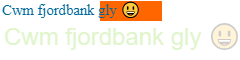

Canvas geometry



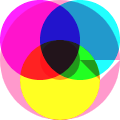

In [20]:
from IPython.display import Image
from IPython.core.display import HTML
print('Canvas text')
display(Image(url= sdf.iloc[0]['Canvas text']))
print('Canvas geometry')
display(Image(url= sdf.iloc[0]['Canvas geometry']))

In [21]:
print('saving survey and browser attributes data to %s'% survey_and_browser_attrs_fpath)
sdf.to_csv(survey_and_browser_attrs_fpath, index=False)
print('...saved')

saving survey and browser attributes data to ../data/survey-and-browser-attributes-data.csv
...saved
